# 温度预测问题
### Step 1：解析数据

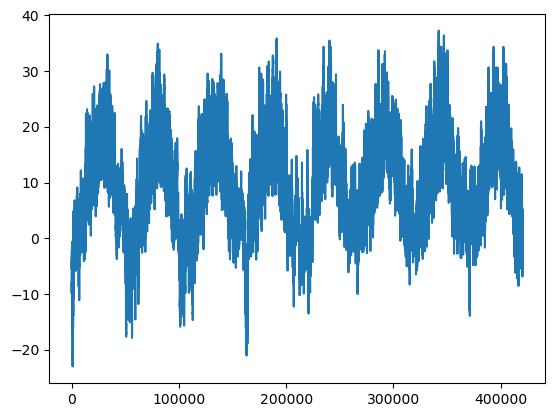

In [1]:
import os

data_dir = "D://ML/jena_climate/"
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

# 绘制温度时间序列
from matplotlib import pyplot as plt
temp = float_data[:, 1] # 温度（单位：摄氏度）
plt.plot(range(len(temp)), temp)

In [2]:
# 数据标准化

mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [4]:
# 生成时间序列样本及其目标的生成器

def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay -1 
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows),
                            lookback // step,
                            data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [5]:
# 准备训练生成器、验证生成器和测试生成器

lookback = 1440
step = 6
delay = 144
batch_size = 128
train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)

val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)

test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) //batch_size 

test_steps = (len(float_data) - 300001 - lookback) //batch_size 

### Step 2：训练并评估一个模型

In [6]:
from keras.models import Sequential 
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1]))) 
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae') 
history = model.fit_generator(train_gen,
                              steps_per_epoch=500, 
                              epochs=20, 
                              validation_data=val_gen, 
                              validation_steps=val_steps)

Epoch 1/20


C:\Users\HP\AppData\Local\Temp\ipykernel_12688\2925522736.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


500/500 [==============================] - 10s 20ms/step - loss: 1.2979 - val_loss: 0.6127
Epoch 2/20
500/500 [==============================] - 10s 20ms/step - loss: 0.4560 - val_loss: 0.3437
Epoch 3/20
500/500 [==============================] - 10s 20ms/step - loss: 0.2973 - val_loss: 0.3265
Epoch 4/20
500/500 [==============================] - 10s 20ms/step - loss: 0.2663 - val_loss: 0.2985
Epoch 5/20
500/500 [==============================] - 10s 20ms/step - loss: 0.2531 - val_loss: 0.3116
Epoch 6/20
500/500 [==============================] - 10s 20ms/step - loss: 0.2436 - val_loss: 0.3156
Epoch 7/20
500/500 [==============================] - 11s 23ms/step - loss: 0.2369 - val_loss: 0.3185
Epoch 8/20
500/500 [==============================] - 10s 20ms/step - loss: 0.2306 - val_loss: 0.3196
Epoch 9/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2275 - val_loss: 0.3231
Epoch 10/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2224 - val_loss:

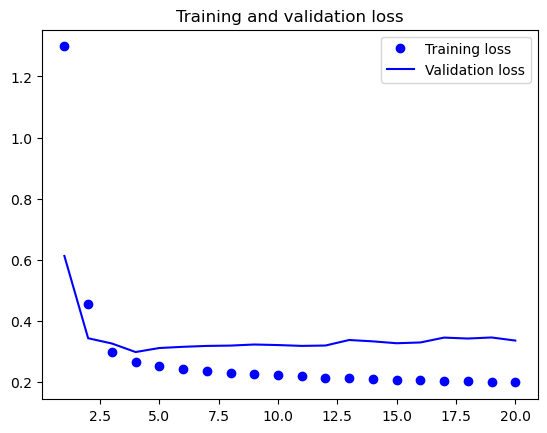

In [7]:
# 绘制结果
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Step 3：使用循环网络训练

In [8]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20


C:\Users\HP\AppData\Local\Temp\ipykernel_12688\3540732871.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


500/500 [==============================] - 59s 114ms/step - loss: 0.3020 - val_loss: 0.2811
Epoch 2/20
500/500 [==============================] - 53s 107ms/step - loss: 0.2848 - val_loss: 0.2647
Epoch 3/20
500/500 [==============================] - 56s 112ms/step - loss: 0.2775 - val_loss: 0.2749
Epoch 4/20
500/500 [==============================] - 52s 104ms/step - loss: 0.2739 - val_loss: 0.2624
Epoch 5/20
500/500 [==============================] - 54s 107ms/step - loss: 0.2688 - val_loss: 0.2670
Epoch 6/20
500/500 [==============================] - 54s 107ms/step - loss: 0.2646 - val_loss: 0.2691
Epoch 7/20
500/500 [==============================] - 54s 109ms/step - loss: 0.2613 - val_loss: 0.2680
Epoch 8/20
500/500 [==============================] - 54s 108ms/step - loss: 0.2554 - val_loss: 0.2690
Epoch 9/20
500/500 [==============================] - 54s 108ms/step - loss: 0.2506 - val_loss: 0.2678
Epoch 10/20
500/500 [==============================] - 53s 106ms/step - loss: 0.2468

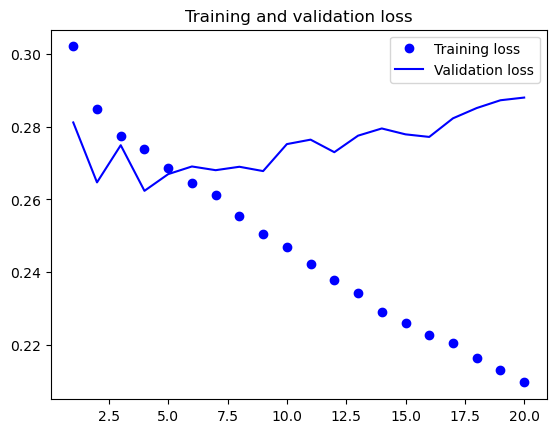

In [9]:
# 绘制结果
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Step 4：使用循环 dropout 来降低过拟合

In [10]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))


model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40


C:\Users\HP\AppData\Local\Temp\ipykernel_12688\2684874413.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


500/500 [==============================] - 81s 158ms/step - loss: 0.3227 - val_loss: 0.2906
Epoch 2/40
500/500 [==============================] - 77s 153ms/step - loss: 0.3071 - val_loss: 0.2822
Epoch 3/40
500/500 [==============================] - 76s 151ms/step - loss: 0.2979 - val_loss: 0.2736
Epoch 4/40
500/500 [==============================] - 77s 153ms/step - loss: 0.2931 - val_loss: 0.2693
Epoch 5/40
500/500 [==============================] - 78s 156ms/step - loss: 0.2898 - val_loss: 0.2846
Epoch 6/40
500/500 [==============================] - 75s 151ms/step - loss: 0.2863 - val_loss: 0.2668
Epoch 7/40
500/500 [==============================] - 74s 149ms/step - loss: 0.2833 - val_loss: 0.2684
Epoch 8/40
500/500 [==============================] - 75s 150ms/step - loss: 0.2771 - val_loss: 0.2681
Epoch 9/40
500/500 [==============================] - 75s 150ms/step - loss: 0.2752 - val_loss: 0.2736
Epoch 10/40
500/500 [==============================] - 78s 156ms/step - loss: 0.2718

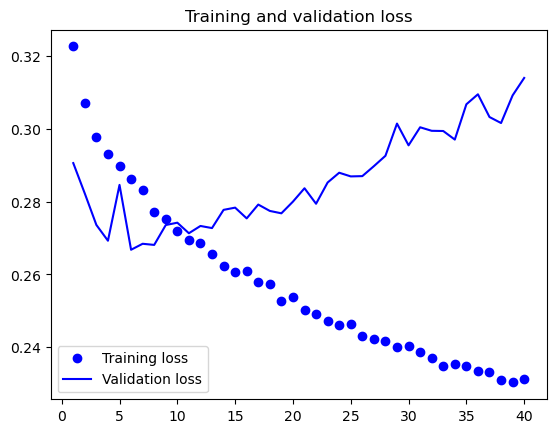

In [11]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Step 5：循环层堆叠

In [12]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1,
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40


C:\Users\HP\AppData\Local\Temp\ipykernel_12688\3101371511.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


500/500 [==============================] - 253s 499ms/step - loss: 0.3200 - val_loss: 0.2810
Epoch 2/40
500/500 [==============================] - 237s 473ms/step - loss: 0.3015 - val_loss: 0.2807
Epoch 3/40
500/500 [==============================] - 232s 465ms/step - loss: 0.2943 - val_loss: 0.2757
Epoch 4/40
500/500 [==============================] - 238s 476ms/step - loss: 0.2859 - val_loss: 0.2659
Epoch 5/40
500/500 [==============================] - 229s 457ms/step - loss: 0.2793 - val_loss: 0.2653
Epoch 6/40
500/500 [==============================] - 229s 458ms/step - loss: 0.2752 - val_loss: 0.2667
Epoch 7/40
500/500 [==============================] - 232s 464ms/step - loss: 0.2711 - val_loss: 0.2732
Epoch 8/40
500/500 [==============================] - 231s 462ms/step - loss: 0.2653 - val_loss: 0.2693
Epoch 9/40
500/500 [==============================] - 230s 460ms/step - loss: 0.2603 - val_loss: 0.2721
Epoch 10/40
500/500 [==============================] - 230s 461ms/step - lo

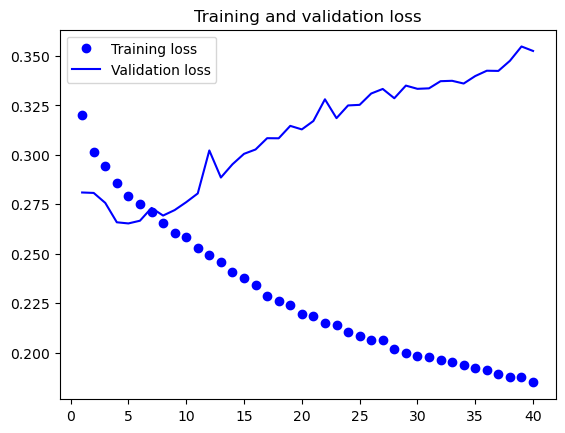

In [13]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()